In [37]:
import PyPDF2
import json
import glob
import numpy as np
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from collections import defaultdict
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

In [2]:
def monthToNum(shortMonth):
    return {
            'January': "01",
            'February': "02",
            'March': "03",
            'April': "04",
            'May': "05",
            'June': "06",
            'July': "07",
            'August': "08",
            'September': "09", 
            'October': "10",
            'November': "11",
            'December': "12"
    }[shortMonth]

def defaultify(d):
        
    if not isinstance(d, dict):
        return d
    return defaultdict(lambda: None, {k: defaultify(v) for k, v in d.items()})

In [3]:
path_output=\
'/Volumes/4TB/ConferenceCall/Tesla/csvfile/tesla_earning_call_question_answer.json'

In [4]:
with open(path_output, 'r') as openfile:
     json_object = json.load(openfile)

In [5]:
def_object=defaultify(json_object)

In [10]:
data_table=\
pd.DataFrame([
              col1, col2, col3, d3
             ]
              for col1, d1 in def_object.items()\
              for col2, d2 in d1.items()\
              for col3, d3 in d2.items()
            )
data_table=data_table.rename(columns={0: 'time',
                                      1: 'company',
                                      2: 'chara1',
                                      3: 'text'}).reset_index(drop=True)

In [11]:
data_table.head()

,time,company,chara1,text
0,"Wednesday, May 04, 2011 9:00 PM GMT\nS&P","Tesla Motors, Inc., Q1 2011 Earnings Call, May...",people,{'analysts': {'Adam Michael Jonas': 'Morgan St...
1,"Wednesday, May 04, 2011 9:00 PM GMT\nS&P","Tesla Motors, Inc., Q1 2011 Earnings Call, May...",question_and_answer,"[Question and Answer\n, Operator\n, [Operator ..."
2,"Wednesday, May 04, 2011 9:00 PM GMT\nS&P","Tesla Motors, Inc., Q1 2011 Earnings Call, May...",executives_answer,"{'answer_0': {'6': ['Sure, our goal with Tesla..."
3,"Wednesday, May 04, 2011 9:00 PM GMT\nS&P","Tesla Motors, Inc., Q1 2011 Earnings Call, May...",analysts_question,{'question_0': {'4': ['So I guess a couple que...
4,"Wednesday, May 04, 2011 9:00 PM GMT\nS&P","Tesla Motors, Inc., Q1 2011 Earnings Call, May...",executives_people_answer,"{'answer_0': 'Elon R. Musk', 'answer_1': 'Elon..."


In [12]:
data_table_01=data_table[data_table['chara1'] == 'executives_answer'].reset_index(drop=True)

In [14]:
data_table_01['text_executives_answer_01']=\
data_table_01.loc[:, 'text'].apply(
    lambda x: list(x.values()))

In [16]:
data_table_01['text_executives_answer_02']=\
data_table_01['text_executives_answer_01'].apply(lambda x: [list(text.values())[0][0] for text in x])

In [20]:
len(data_table_01['text'][0].keys())

49

In [24]:
data_table_01['text'].apply(lambda x: len(x.keys()))

0      50
1      78
2      46
3      52
4      98
5      78
6      44
7     126
8      49
9      70
10    111
11     59
12     44
13     42
14     54
15     45
16     94
17     81
18     97
19     26
20     59
21     44
22     54
23     95
24     77
25     98
26     98
27     57
28     49
29     33
30     70
31     66
32    107
33    162
34     58
35     58
36     55
37     70
38     63
39    107
40     87
41     55
42     54
43     94
44     72
45     70
46     79
47     76
48     40
49     62
50     47
51     83
Name: text, dtype: int64

In [28]:
data_table_01["call_date"]=data_table_01["time"].apply(lambda x: x.split(',')[1])
data_table_01["call_year"]=\
data_table_01["time"].apply(lambda x: x.split(',')[2][0:5])
data_table_01["call_time"]=\
data_table_01["time"].apply(lambda x: x.split(',')[2][5:11])
data_table_01["quarter"]=\
data_table_01["company"].apply(lambda x: x.split(',')[2][:3])
data_table_01["year_quarter"]=\
data_table_01["company"].apply(lambda x: x.split(',')[2][3:9])
data_table_01["company_name"]=data_table_01["company"].apply(lambda x: x.split(',')[0][0:12])
data_table_01=data_table_01.sort_values(['year_quarter', 'quarter'])
data_table_01=data_table_01.reset_index(drop=True)

In [29]:
data_table_01['call_month']=\
data_table_01['call_date'].apply(
    lambda x: x.split(' ')[1]).apply(
    lambda x: monthToNum(x))

data_table_01['call_day']=\
data_table_01['call_date'].apply(
    lambda x: x.split(' ')[2])

cols = data_table_01.loc[:, ['call_year', 'call_month', 'call_day']].columns
data_table_01['call_datetime']=\
data_table_01[cols].apply(
    lambda x: '-'.join(x.dropna().astype(str)), 1)

In [31]:
data_table_01=data_table_01.sort_values(['call_datetime'])

In [35]:
prenum=data_table_01['text'].apply(lambda x: len(x.keys()))

In [34]:
date=data_table_01['call_datetime'].drop_duplicates().reset_index(drop=True)

In [39]:
date=\
pd.to_datetime(date, format='%Y-%m-%d')

In [43]:
np.mean(prenum)

70.0576923076923

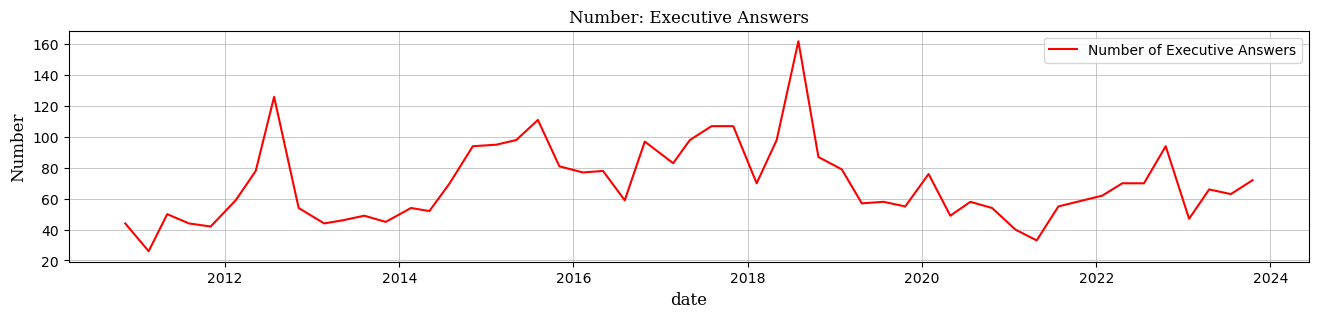

In [45]:
csfont = {'fontname':'serif'}
sizetext=12

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 3))

lns1=\
ax1.plot(date, prenum, label='Number of Executive Answers', color='r')

ax1.set_title("Number: Executive Answers", **csfont, size = sizetext)
ax1.set_ylabel('Number', size = sizetext, **csfont)
ax1.set_xlabel('date', size = sizetext, **csfont)
# ax1.set_xlim([datetime(2010, 11, 9), datetime(2022, 12, 31)]) 
ax1.grid(linewidth=0.5)
ax1.legend()

In [210]:
data_table_01["call_date"]=data_table_01["time"].apply(lambda x: x.split(',')[1])
data_table_01["call_year"]=\
data_table_01["time"].apply(lambda x: x.split(',')[2][0:5])
data_table_01["call_time"]=\
data_table_01["time"].apply(lambda x: x.split(',')[2][5:11])
data_table_01["quarter"]=\
data_table_01["company"].apply(lambda x: x.split(',')[2][:3])
data_table_01["year_quarter"]=\
data_table_01["company"].apply(lambda x: x.split(',')[2][3:9])
data_table_01["company_name"]=data_table_01["company"].apply(lambda x: x.split(',')[0][0:12])
data_table_01=data_table_01.sort_values(['year_quarter', 'quarter'])
data_table_01=data_table_01.reset_index(drop=True)

data_table_01['call_month']=\
data_table_01['call_date'].apply(
    lambda x: x.split(' ')[1]).apply(
    lambda x: monthToNum(x))

data_table_01['call_day']=\
data_table_01['call_date'].apply(
    lambda x: x.split(' ')[2])

cols = data_table_01.loc[:, ['call_year', 'call_month', 'call_day']].columns
data_table_01['call_datetime']=\
data_table_01[cols].apply(
    lambda x: '-'.join(x.dropna().astype(str)), 1)

data_table_01=\
data_table_01[['time',
                'call_datetime',
                'call_year',
                'call_month',
                'call_day',
                'company_name',
                'company',
                'quarter',
                'year_quarter',
                'executives_answer']]

In [211]:
path_output=\
'/Volumes/4TB/ConferenceCall/Tesla/csvfile/tesla_earning_call_executives_answer.csv'

data_table_01.to_csv(path_output, index = False)

In [212]:
data_table_02=data_table[data_table['chara1'] == 'analysts_question'].reset_index(drop=True)

data_table_02['text_analysts_question_01']=\
data_table_02.loc[:, 'text'].apply(
    lambda x: list(x.values()))

data_table_02['text_analysts_question_02']=\
data_table_02['text_analysts_question_01'].apply(lambda x: [list(text.values())[0][0] for text in x])

data_table_02['text_analysts_question_02']=\
data_table_02['text_analysts_question_02'].apply(lambda x: " ".join([text for text in x]))

In [213]:
data_table_02=data_table_02[['time', 'company', 'chara1', 'text_analysts_question_02']]

data_table_02=\
pd.pivot(data_table_02,
         values=['text_analysts_question_02'],
         index=['time', 'company'],
         columns=['chara1'])

data_table_02=data_table_02['text_analysts_question_02'].reset_index(drop=False)

data_table_02["call_date"]=data_table_02["time"].apply(lambda x: x.split(',')[1])
data_table_02["call_year"]=\
data_table_02["time"].apply(lambda x: x.split(',')[2][0:5])
data_table_02["call_time"]=\
data_table_02["time"].apply(lambda x: x.split(',')[2][5:11])
data_table_02["quarter"]=\
data_table_02["company"].apply(lambda x: x.split(',')[2][:3])
data_table_02["year_quarter"]=\
data_table_02["company"].apply(lambda x: x.split(',')[2][3:9])
data_table_02["company_name"]=data_table_02["company"].apply(lambda x: x.split(',')[0][0:12])
data_table_02=data_table_02.sort_values(['year_quarter', 'quarter'])
data_table_02=data_table_02.reset_index(drop=True)

data_table_02['call_month']=\
data_table_02['call_date'].apply(
    lambda x: x.split(' ')[1]).apply(
    lambda x: monthToNum(x))

data_table_02['call_day']=\
data_table_02['call_date'].apply(
    lambda x: x.split(' ')[2])

cols = data_table_02.loc[:, ['call_year', 'call_month', 'call_day']].columns
data_table_02['call_datetime']=\
data_table_02[cols].apply(
    lambda x: '-'.join(x.dropna().astype(str)), 1)

data_table_02=\
data_table_02[['time',
                'call_datetime',
                'call_year',
                'call_month',
                'call_day',
                'company_name',
                'company',
                'quarter',
                'year_quarter',
                'analysts_question']]

In [214]:
path_output=\
'/Volumes/4TB/ConferenceCall/Tesla/csvfile/tesla_earning_call_analysts_question.csv'

data_table_02.to_csv(path_output, index = False)